### The calculation of the invariant mass from the 4-vectors $p_1,p_2$ and what else is relevant can be learnt by a Neural Network

In [1]:
import uproot
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
# We use uproot https://github.com/scikit-hep/uproot 
# to read our root file.
# Different to numpy_root we do not need a ROOT installation. Uproot knows the ROOT file format
# uproot uses dictionaries to access the file content
file = uproot.open("toy.root")
tree = file["tree"]
tree.keys()

['Pt1',
 'Eta1',
 'Phi1',
 'E1',
 'Pt2',
 'Eta2',
 'Phi2',
 'E2',
 'Px1',
 'Py1',
 'Pz1',
 'Px2',
 'Py2',
 'Pz2',
 'pz',
 'mass',
 'dphi',
 'weight',
 'label']

We have 21780 events


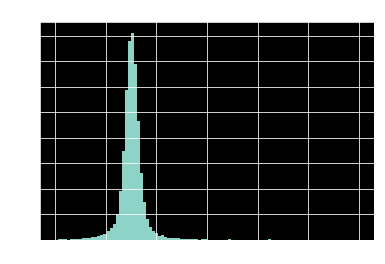

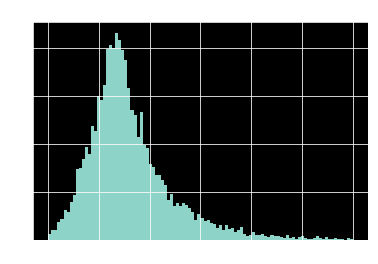

In [3]:
# uproot provides an convenient interface to pandas
df=tree.pandas.df(["mass","Pt1", "Pz1", "E1","Phi1","Eta1","Pt2", "Pz2","E2","Phi2","Eta2","label"])
# reduced variables
# df=tree.pandas.df(["mass","Pt1", "Pz1","Eta1","Pt2", "Pz2","Eta2","label"])


#select physical masses and subsample to make the example faster

df=df[df.mass>0]
# the file contains the signal first
# we reshuffle and take a sub sample to make the example faster
# left with about ~22k events
df = df.sample(frac=0.25).reset_index(drop=True)
df[df.label==1].hist(["mass"],bins=100,range=[0,3000])
df[df.label==0].hist(["mass"],bins=100,range=[0,3000])
print 'We have %d events' %len(df)

In [4]:
# we cut a mass window
# and calculate the acc if we take all
# events in the window as signal
window  = (df.mass>645) & (df.mass<915)
sigWin  = (df[window].label==1).sum()
bgrdWin = (df[window].label==0).sum()
allSig  = (df.label==1).sum()
allBgrd = (df.label==0).sum()
trueLabels=sigWin+(allBgrd-bgrdWin)
allEvts  =allSig+allBgrd
acc=trueLabels/float(allEvts)
print acc

0.7801652892561983


In [9]:
#!pip install sklearn
import numpy as np
# sklearn provides a convenient funtion to split our dataset randomly
# into training and testing datasets 
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split


# we want to learn the label signal/background
Y=df["label"].values

# and take Pt1,Eta1,Phi1,E1,Pt2,Eta2,Phi2,E2 as input features
# using the calcuated mass would be to easy

X=df.drop(["mass","label"],axis=1).values


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print 'X_train: ',type(X_train),X_train.shape,X_train.dtype
print 'Y_train: ',type(Y_train),Y_train.shape,Y_train.dtype
print 'X_test: ',type(X_test),X_test.shape,X_test.dtype
print 'Y_test: ',type(Y_test),Y_test.shape,Y_test.dtype
print 'We use', len(Y_train),'for training.'

X_train:  <type 'numpy.ndarray'> (14592, 10) float32
Y_train:  <type 'numpy.ndarray'> (14592,) int32
X_test:  <type 'numpy.ndarray'> (7188, 10) float32
Y_test:  <type 'numpy.ndarray'> (7188,) int32
We use 14592 for training.


In [10]:
print df['Pt1'][0],X[0,0]

337.43622 337.43622


In [11]:
#move to classification
# It is almost always a good idea to normalize the data before training
# http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

# Standardize features by removing the mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler

# we keep the origina data untouched and create a scaled copy
scaler = StandardScaler(copy=True) 

# we normalize our data
X_scaled_train = scaler.fit_transform(X_train)
# aplly the same transformation to the test sample
X_scaled_test  = scaler.transform(X_test)
print type(X_scaled_train ),type(X_train)

<type 'numpy.ndarray'> <type 'numpy.ndarray'>


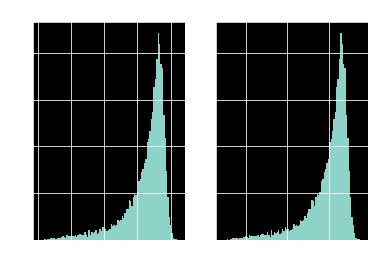

In [12]:
#to show the scaling
pt1        = X_train[:,0]
pt1_scaled = X_scaled_train[:,0]

plt.subplot(121)
plt.title('Pt1')
plt.grid(True)
#plt.yscale('log')
plt.hist(pt1,bins=100)
plt.subplot(122)
plt.title('Pt1 - scaled')
plt.grid(True)
#plt.yscale('log')
plt.hist(pt1_scaled,bins=100)
plt.show()

In [13]:
print X_train[:,0].mean(),X_scaled_train[:,0].mean()
print X_train[:,0].var(),X_scaled_train[:,0].var()

325.85886 -4.3077425e-06
3890.0723 1.0000046


In [14]:
print Y_train.sum(),'signal events',(Y_train==0).sum(),'background events',len(Y_train)

8268 signal events 6324 background events 14592


### We build our NN

In [17]:
import torch
from time import time

dtype  = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0") # Uncomment this to run on GPU


# pyTorchViz is a little tool to visualize pyTorch's execution graph
# https://github.com/szagoruyko/pytorchviz
from torchviz import make_dot

# to keep things simple
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.

D_in, H, D_out = X.shape[1], 10, 1
print 'Number of features',D_in

# Create input and output torch tensors from previous numpy array
# with respect to these Tensors during the backward pass.
x_train = torch.from_numpy(X_scaled_train).float().to(device)
y_train = torch.from_numpy(Y_train).float().to(device)
x_test  = torch.from_numpy(X_scaled_test).float().to(device)
y_test  = torch.from_numpy(Y_test).float().to(device)


# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.Sigmoid()
)
model.to(device)
#loss_fn = torch.nn.BCELoss(reduction='elementwise_mean')
loss_fn = torch.nn.BCELoss()


# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 0.008
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,amsgrad=False)


L=[]

n_steps=50
batch_size = 128

import torch.utils.data
dataset      = torch.utils.data.TensorDataset(x_train, y_train)
data_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle = True)
n_inner=float(len(data_loader))

t0=time()
for epoch in range(n_steps):
    av_loss=0
    step=0
    t = time()
    for x,y in data_loader:
        x = x.to(device)
        y = y.to(device)
        
        # Forward pass: compute predicted y by passing x to the model.
        #y_pred = model(x).reshape(len(y))
        y_pred = model(x)#.flatten()
        # Compute and print loss.
        loss = loss_fn(y_pred, y)

        with torch.no_grad():
            av_loss+=loss.item()

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
    
    with torch.no_grad():
        #loss_train = loss_fn(model(x_train).flatten(),y_train).item()
        av_loss/=n_inner # to gain some sensitivy to the inner loop
        #loss_test  = loss_fn(model(x_test).flatten(), y_test).item()
        loss_test  = loss_fn(model(x_test), y_test).item()
    #torch.cuda.synchronize()
    dt  = time()-t
    tot = time()-t0
    print "Epoch %4d (%0.3f s tot: %0.3f s) av. loss train: %0.3f - lost test %0.3f" \
    % (epoch, dt, tot, av_loss, loss_test)
    L.append([av_loss,loss_test])



Number of features 10
Epoch    0 (0.173 s tot: 0.173 s) av. loss train: 0.507 - lost test 0.294


/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([7188])) that is different to the input size (torch.Size([7188, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch    1 (0.228 s tot: 0.402 s) av. loss train: 0.204 - lost test 0.153
Epoch    2 (0.235 s tot: 0.637 s) av. loss train: 0.131 - lost test 0.114
Epoch    3 (0.168 s tot: 0.806 s) av. loss train: 0.108 - lost test 0.097
Epoch    4 (0.224 s tot: 1.030 s) av. loss train: 0.094 - lost test 0.088
Epoch    5 (0.263 s tot: 1.294 s) av. loss train: 0.084 - lost test 0.082
Epoch    6 (0.168 s tot: 1.462 s) av. loss train: 0.078 - lost test 0.078
Epoch    7 (0.170 s tot: 1.632 s) av. loss train: 0.073 - lost test 0.074
Epoch    8 (0.167 s tot: 1.800 s) av. loss train: 0.070 - lost test 0.070
Epoch    9 (0.173 s tot: 1.973 s) av. loss train: 0.064 - lost test 0.067
Epoch   10 (0.174 s tot: 2.147 s) av. loss train: 0.061 - lost test 0.064
Epoch   11 (0.266 s tot: 2.414 s) av. loss train: 0.056 - lost test 0.062
Epoch   12 (0.276 s tot: 2.691 s) av. loss train: 0.055 - lost test 0.058
Epoch   13 (0.168 s tot: 2.859 s) av. loss train: 0.051 - lost test 0.056
Epoch   14 (0.170 s tot: 3.029 s) av. 

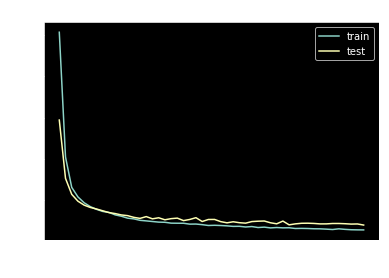

Sequential(
  (0): Linear(in_features=10, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
  (3): Sigmoid()
)


In [18]:
# we plot the learning curve
Xaxis = np.arange(0,len(L))
plt.title('loss eveolution')
lns=plt.plot(Xaxis,L)
plt.legend(lns, ('train', 'test')) 
plt.xlabel('epochs')
plt.ylabel('BCEloss/evt')
#plt.yscale('log')
plt.show()

#visualize the network
#out
print model
#Plot without loss: make_dot(model(x), params=dict(model.named_parameters()))
#make_dot(loss,params=dict(model.named_parameters()))

### We note that the loss becomes flat and the test error is above the train error

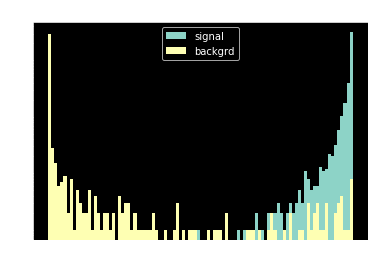

In [19]:
# apply learned
# get everything back to cpu
model.cpu()

x_test=x_test.cpu()
y_test=y_test.cpu()

y_pred = model(x_test).detach().numpy()
y_true = y_test.numpy()

plt.title('classifier')
#plt.grid(False)
plt.yscale('log')
plt.hist(y_pred[y_true==1],bins=100,range=[0,1],label='signal')
plt.hist(y_pred[y_true==0],bins=100,range=[0,1],label='backgrd')
plt.legend()
plt.xlabel('classifier output')
plt.show()

### It seems that the separation works extremly good

In [20]:
# the quality of the classifier can be checked by standard scores like
# like accuracy and auc (area under the receiver operator curve, 
# i.e. true positive over false positive)
# sklearn provides many useful tools for this

from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score
acc = accuracy_score(y_true, y_pred>0.5, normalize=True)
auc = roc_auc_score(y_true, y_pred>0.5)
print acc,auc

0.9912353923205343 0.9902316406029348


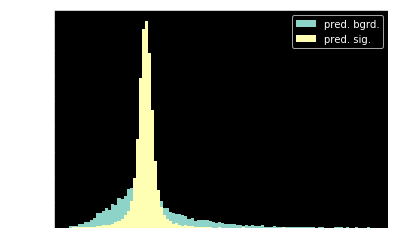

In [21]:
# test on all
X_scaled_all  = scaler.transform(X)
Y_all = Y
Y_pred = model(torch.tensor(X_scaled_all)).detach().numpy()

#add columns to df
df['y_pred']= Y_pred

# we plot the invariant mass for the events that are selected as signal/background 
# by our NN classifier
df[df.y_pred<0.5].mass.plot.hist(bins=100,range=[0,3000],label='pred. bgrd.')
df[df.y_pred>0.5].mass.plot.hist(bins=100,range=[0,3000],label='pred. sig.')
plt.legend()
plt.show()

### What give the seperation?

In [23]:
# we replace one column after the other by its reshuffled version
# with the help of a random index and evaluate the model 
# on the 1-bin-reshuffled data and print the accuracy

# the variable names
names=df.keys()[1:11]

xall=torch.tensor(X_scaled_all)

# an index to randomize
idx=np.random.permutation(X_scaled_all.shape[0])

# for our 10 parameters that runs from 0..9
for i in range(X_scaled_all.shape[1]): 
    #replace one column by its permutation
    xall[:,i]=xall[idx,i]
    Y_pred = model(xall).detach().numpy()
    acc = accuracy_score(Y_all, Y_pred>0.5, normalize=True)
    print 'acc w/o %5s %0.4f'%(names[i],acc)
    #reestablish the old order
    xall[:,i]=torch.tensor(X_scaled_all[:,i])


acc w/o   Pt1 0.8303
acc w/o   Pz1 0.5538
acc w/o    E1 0.9509
acc w/o  Phi1 0.9905
acc w/o  Eta1 0.5449
acc w/o   Pt2 0.8245
acc w/o   Pz2 0.5800
acc w/o    E2 0.9668
acc w/o  Phi2 0.9907
acc w/o  Eta2 0.5730


### Try to reduce the number of variables and see how big the influence on the accuracy is